In [1]:
import sys, os

sys.path.append(os.path.abspath(
    os.getcwd()+"/src")
)

In [ ]:
from src.data_management import deformation_from_name
from src.data_gen import deformation_to_image_mapper
from src.benchmark import benchmark_nn_decoder

from qecsim.models.rotatedplanar import RotatedPlanarCode
from qecsim.models.generic import BiasedDepolarizingErrorModel

import jax.numpy as jnp
from jax import random

key = random.key(0)

In [3]:
code = RotatedPlanarCode(3,3)
error_probabilities = jnp.array(BiasedDepolarizingErrorModel(
    bias=500, axis='Z'
).probability_distribution(0.1))
deformation = deformation_from_name(code, 'C1')
deformation_img = deformation_to_image_mapper(code)(deformation)[None,:,:,:]

Logical error rate is 41.72% under a physical error rate of 10.00%


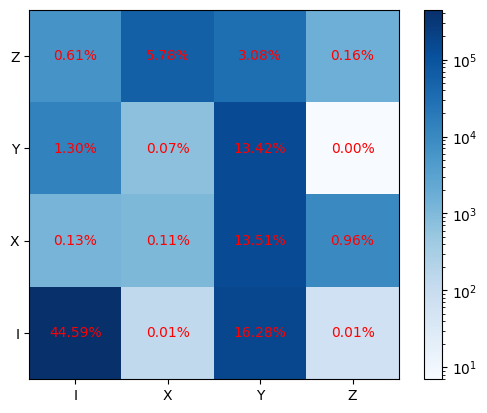

In [16]:
ler, hist2d = benchmark_nn_decoder(random.key(0), 1_000_000, 'C2_d3', code, error_probabilities, deformation, with_histogram_2d=True)
print(f"Logical error rate is {ler:.2%} under a physical error rate of {error_probabilities[1:].sum():.2%}")

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(hist2d, cmap='Blues', interpolation='nearest', norm='log')
for i in range(4):
    for j in range(4):
        plt.text(j, i, f"{hist2d[i, j] / hist2d.sum() :.2%}", ha='center', va='center', color='red')
plt.colorbar()
plt.gca().invert_yaxis()
plt.yticks(range(4), ['I', 'X', 'Y', 'Z'])
plt.xticks(range(4), ['I', 'X', 'Y', 'Z'])
plt.show()